In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 

# PREPROCESSING MODULES
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA

# CLASSIFIER MODULES
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# METRIC MODULES
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score, recall_score, precision_score, fbeta_score, confusion_matrix, make_scorer, ConfusionMatrixDisplay, roc_curve, auc, plot_roc_curve, plot_precision_recall_curve

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
%config InlineBackend.figure_format = 'retina'


In [110]:
df = pd.read_csv('data/combined_cleaned.csv')

# CONVERT STRING INTO LISTS
df['genres'] = df['genres'].str.split(', ')
df['tags'].fillna('',inplace=True)
df['tags'] = df['tags'].str.split(', ')
df['platforms'] = df['platforms'].str.split(', ')
df['categories'] = df['categories'].str.split(', ')
df['supported_languages'] = df['supported_languages'].str.split(', ')
df['supported_languages_audio'].fillna('',inplace=True)
df['supported_languages_audio'] = df['supported_languages_audio'].str.split(', ')
df['publishers'].fillna('',inplace=True)
df['publishers'] = df['publishers'].str.split(', ')

# TARGET VARIABLE
df['target'] = (df['hours_over_age'] >= 1).astype(int)
print(df.shape)

X = df[[
    'tags',
    'genres','categories','platforms',
        'supported_languages','supported_languages_audio',
        'historic_developer_average_recommendations','historic_developer_average_owners','historic_developer_average_hours',
        'historic_publisher_average_recommendations','historic_publisher_average_owners','historic_publisher_average_hours'
        ]]

y = df['target']

sss = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)
train_index, test_index = next(sss.split(np.zeros(len(df['target'])), df['target']))
X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]


(41647, 41)


In [111]:
class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:,i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.'
                            )
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))

        result = np.concatenate(result, axis=1)
        return result

In [112]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=list(['missing']))),
    ('multihot', MultiHotEncoder())
])

tag_transformer = Pipeline(steps=[
    ('multihot', MultiHotEncoder()),
    ('pca', PCA(250))
])

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
print('numeric_features',numeric_features)
categorical_features = X_train.select_dtypes(include=['object']).columns
print('categorical_features',categorical_features)
# try:
#     tag_features = X_train[['tags']].columns
# except:
#     tag_features = []
# print('tags',tag_features)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
#         ('tag', tag_transformer, tag_features)
    ])

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(200,class_weight={1: 10, 0: 1}))])
""
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier(n_estimators=500,
                                                       use_label_encoder=False,
                                                       max_depth=6,
                                                       objective='binary:logistic', #new objective
                                                       learning_rate=.05, 
                                                       subsample=.8,
                                                       min_child_weight=2,
                                                       colsample_bytree=.8,
                                                       scale_pos_weight=10
                                                      )
                      )
                    ])




numeric_features Index(['historic_developer_average_recommendations',
       'historic_developer_average_owners', 'historic_developer_average_hours',
       'historic_publisher_average_recommendations',
       'historic_publisher_average_owners',
       'historic_publisher_average_hours'],
      dtype='object')
categorical_features Index(['tags', 'genres', 'categories', 'platforms', 'supported_languages',
       'supported_languages_audio'],
      dtype='object')


In [37]:
param_grid = { 
#     'classifier__n_estimators': [200, 500],
    'classifier__max_depth' : [6],
    'classifier__min_child_weight': [1,2,3],
#     'classifier__criterion' :['gini', 'entropy'],
    'classifier__scale_pos_weight' :[10,20,30],
    'classifier__eval_metric' :['auc']
}

fbeta_scorer = make_scorer(fbeta_score, beta=0.6)

cv = StratifiedKFold(n_splits=2, random_state=42)

grid = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=fbeta_scorer)

grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
# cm = confusion_matrix(y_test, y_pred)
# Best: 0.391427 using {'classifier__eval_metric': 'auc', 'classifier__max_depth': 6, 'classifier__scale_pos_weight': 20}

Best: 0.408472 using {'classifier__eval_metric': 'auc', 'classifier__max_depth': 6, 'classifier__min_child_weight': 2, 'classifier__scale_pos_weight': 10}


## Baseline Model: Random Forest n_est=200

precision:  0.2198581560283688
recall:  0.13596491228070176
fbeta : 0.17719224871044192
['genres', 'categories', 'platforms']


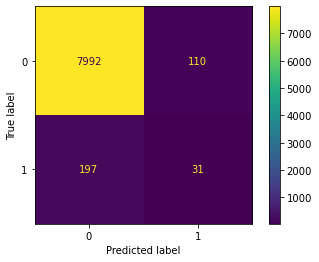

In [58]:
rf_pipeline.fit(X_train,y_train)
y_predict = rf_pipeline.predict(X_test)
print('precision: ', precision_score(y_test,y_predict))
print('recall: ', recall_score(y_test,y_predict))
print('fbeta :', fbeta_score(y_test, y_predict,beta=0.8))
cm = confusion_matrix(y_test, y_predict)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(list(X_train.columns))

In [114]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
rf_probs = rf_pipeline.predict_proba(X_test)[:,1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (rf_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, rf_probs)
# plot the roc curve for the model
plt.figure(figsize=(7,7))
plt.plot(ns_fpr, ns_tpr, linestyle='--', color='grey', label='No Skill')
plt.plot(lr_fpr, lr_tpr, linewidth=4, color='#1754f1ff', label='Random Forest (AUC: {:.3f})'.format(rf_auc))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc='lower right',shadow=True)
# show the plot
plt.savefig('images/baseline_roc.svg',transparent=True,dpi=200)
plt.show()

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

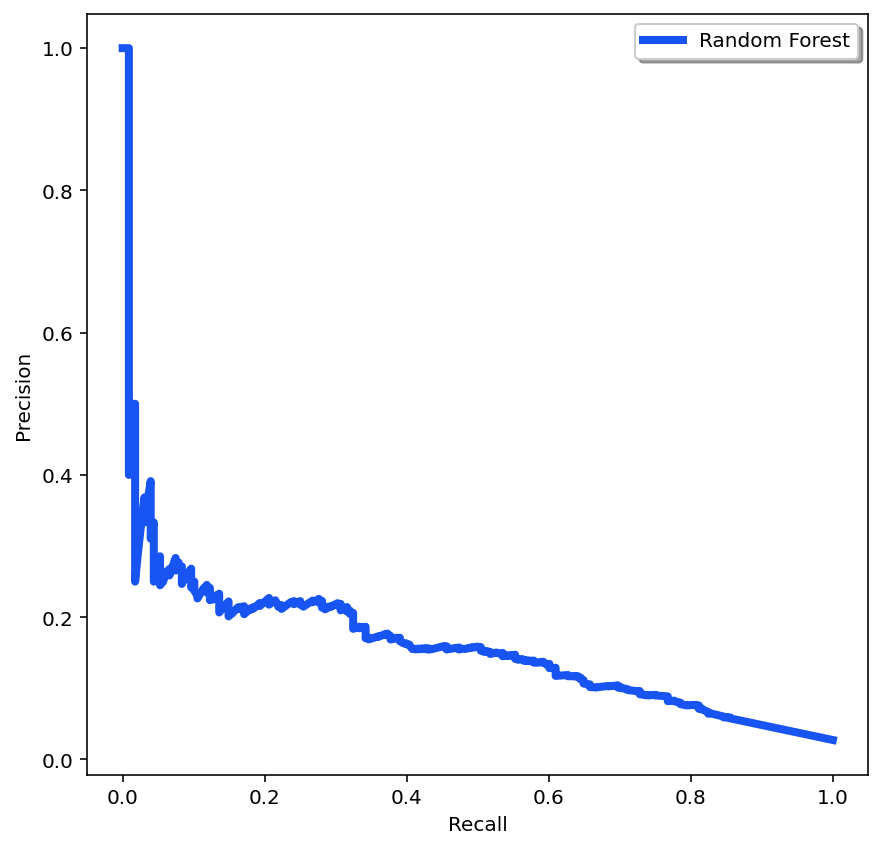

In [108]:
# keep probabilities for the positive outcome only
rf_probs = rf_pipeline.predict_proba(X_test)[:,1]
# calculate recall curves
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
# plot the roc curve for the model
plt.figure(figsize=(7,7))
plt.plot(rf_recall, rf_precision, linewidth=4, color='#1754f1ff', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend(loc='upper right',shadow=True)
# show the plot
plt.savefig('images/baseline_pr.svg',transparent=True,dpi=200)
plt.show()

## XGBoost

precision:  0.4007352941176471
recall:  0.4780701754385965
f1 : 0.43600000000000005
fbeta : 0.4277373660030629
Index(['tags', 'genres', 'categories', 'platforms', 'supported_languages',
       'supported_languages_audio',
       'historic_developer_average_recommendations',
       'historic_developer_average_owners', 'historic_developer_average_hours',
       'historic_publisher_average_recommendations',
       'historic_publisher_average_owners',
       'historic_publisher_average_hours'],
      dtype='object')


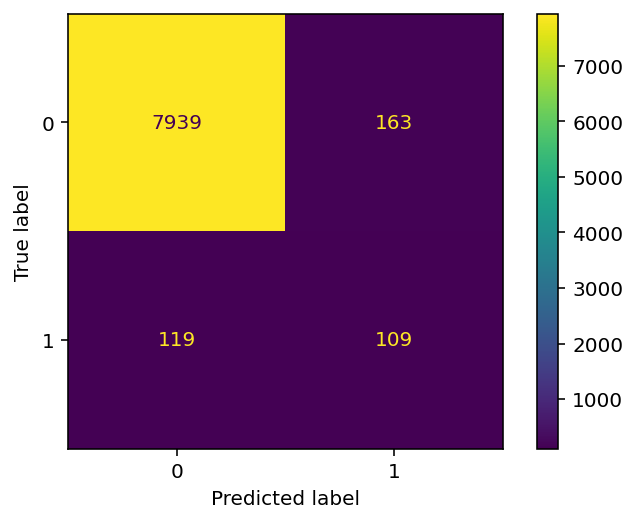

In [113]:
xgb_pipeline.fit(X_train,y_train,classifier__eval_metric='auc')
y_predict = xgb_pipeline.predict(X_test)
print('precision: ', precision_score(y_test,y_predict))
print('recall: ', recall_score(y_test,y_predict))
print('f1 :', f1_score(y_test, y_predict))
print('fbeta :', fbeta_score(y_test, y_predict,beta=0.8))
cm = confusion_matrix(y_test, y_predict)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(X_train.columns)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.819
xg_auc: ROC AUC=0.922


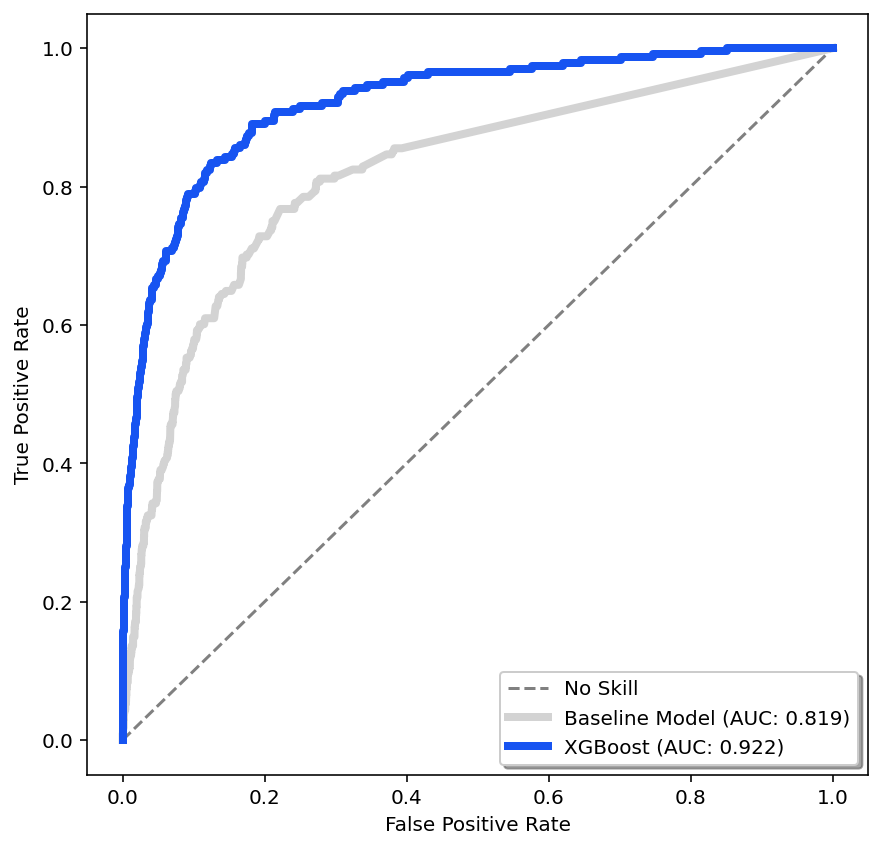

In [124]:

# keep probabilities for the positive outcome only
xg_probs = xgb_pipeline.predict_proba(X_test)[:,1]

xg_auc = roc_auc_score(y_test, xg_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (rf_auc))

print('xg_auc: ROC AUC=%.3f' % (xg_auc))


xg_fpr, xg_tpr, _ = roc_curve(y_test, xg_probs)
# plot the roc curve for the model
plt.figure(figsize=(7,7))
plt.plot(ns_fpr, ns_tpr, linestyle='--', color='grey', label='No Skill')
plt.plot(lr_fpr, lr_tpr, linewidth=4, color='lightgrey', label='Baseline Model (AUC: {:.3f})'.format(rf_auc))

plt.plot(xg_fpr, xg_tpr, linewidth=4, color='#1754f1ff', label='XGBoost (AUC: {:.3f})'.format(xg_auc))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc='lower right',shadow=True)
# show the plot
plt.savefig('images/xgb_roc.svg',transparent=True,dpi=200)
plt.show()


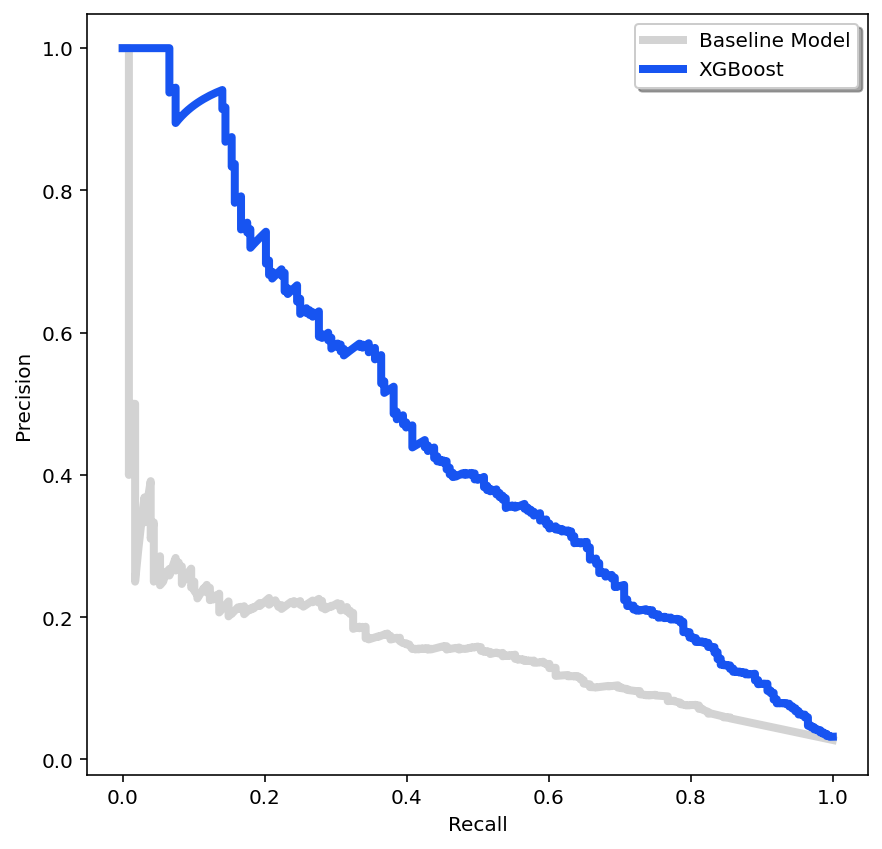

In [125]:

# calculate recall curves
xg_precision, xg_recall, _ = precision_recall_curve(y_test, xg_probs)
# plot the roc curve for the model
plt.figure(figsize=(7,7))
plt.plot(rf_recall, rf_precision, linewidth=4, color='lightgrey', label='Baseline Model')

plt.plot(xg_recall, xg_precision, linewidth=4, color='#1754f1ff', label='XGBoost')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend(loc='upper right',shadow=True)
# show the plot
plt.savefig('images/xgb_pr.svg',transparent=True,dpi=200)
plt.show()

precision:  0.2796116504854369
recall:  0.631578947368421
f1 : 0.3876177658142665
fbeta : 0.35732009925558317
Index(['tags', 'genres', 'categories', 'platforms', 'supported_languages',
       'supported_languages_audio',
       'historic_developer_average_recommendations',
       'historic_developer_average_owners', 'historic_developer_average_hours',
       'historic_publisher_average_recommendations',
       'historic_publisher_average_owners',
       'historic_publisher_average_hours'],
      dtype='object')


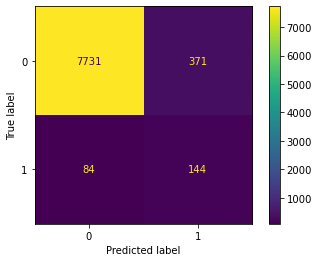

In [41]:
xgb_pipeline.fit(X_train,y_train,classifier__eval_metric='auc')
y_predict = xgb_pipeline.predict(X_test)
print('precision: ', precision_score(y_test,y_predict))
print('recall: ', recall_score(y_test,y_predict))
print('f1 :', f1_score(y_test, y_predict))
print('fbeta :', fbeta_score(y_test, y_predict,beta=0.8))
cm = confusion_matrix(y_test, y_predict)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(X_train.columns)

(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x7fb623c45430>,
 <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x7fb623c7fdf0>)

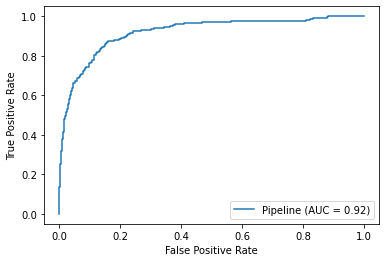

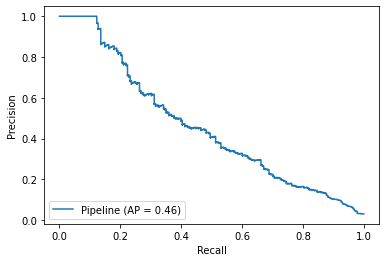

In [39]:
plot_roc_curve(xgb_pipeline,X_test,y_test), plot_precision_recall_curve(xgb_pipeline,X_test,y_test)
